In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from src import infer

In [2]:
df = pd.read_csv('inputs/dataset.csv')

#gather all enrolled
enrolled = df.loc[df['Target'] == 'Enrolled']
imputed_df = df.loc[df['Target'] != 'Enrolled']

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# for train and test drop all enrolled
train_df = train_df.loc[train_df['Target'] != 'Enrolled']
#print(train_df[:10])
test_df_en = test_df.copy()
test_df = test_df.loc[test_df['Target'] != 'Enrolled']

# Train rf on train
rf = RandomForestClassifier(n_estimators = 100,random_state=42)
rf.fit(train_df.drop(columns=['Target']),train_df['Target'])

# test rf on valid
print(rf.score(test_df.drop(columns=['Target']),test_df['Target']))
predse = rf.predict(test_df_en.drop(columns=['Target']))
#print(predse[:20])
print(accuracy_score(test_df_en['Target'],predse))

#predict on enrolled
ypreds = rf.predict(enrolled.drop(columns=['Target']))
enrolled['Target'] = ypreds

#print(enrolled[:10])

#concat

imputed_df = pd.concat([imputed_df, enrolled], axis=0)

0.8950953678474114
0.7423728813559322


C:\Users\saffa\AppData\Local\Temp\ipykernel_11632\3980505784.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrolled['Target'] = ypreds


In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

target_dict = {
    'Dropout':0,
    'Graduate':1,
    }

df['Target'] = df['Target'].map(target_dict)

X = imputed_df.drop(columns=['Target'])
y = imputed_df['Target']

clf.fit(X,y)

RandomForestClassifier()

In [4]:
from skops import hub_utils, card
import os
import joblib

# create a directory to initialize our repo
local_repo = "./model_dir"
# save the model
pkl_path = "./model.pkl"
joblib.dump(clf, pkl_path)
joblib.dump(clf, "models/final_rf.bin")

# initialize the repository 
hub_utils.init(model=pkl_path, 
               task="tabular-classification",
               requirements=["scikit-learn"], 
               dst=local_repo,
               data=X)

# see what's inside the repository
print(os.listdir(local_repo))

['config.json', 'model.pkl']


In [5]:
from pathlib import Path
model_card = card.Card(clf, metadata=card.metadata_from_config(Path(local_repo)))

In [6]:
description = "This is a RandomForest Classifier trained on student academic performance data."
limitations = "This model is trained for educational purposes."
model_card.add(model_description = description,
              limitations = limitations)

Card(
  model=RandomForestClassifier(),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=model.pkl,
  metadata.widget={...},
  Model description/Training Procedure/Hyperparameters=TableSection(18x2),
  Model description/Training Procedure/...</pre></div></div></div></div></div>,
  model_description=This is a RandomFor...n student academic performance data.,
  limitations=This model is trained for educational purposes.,
)

In [7]:
model_card.add_metrics(**{"accuracy": 0.9041, "roc_auc": 0.9157})

Card(
  model=RandomForestClassifier(),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=model.pkl,
  metadata.widget={...},
  Model description/Training Procedure/Hyperparameters=TableSection(18x2),
  Model description/Training Procedure/...</pre></div></div></div></div></div>,
  Model description/Evaluation Results=TableSection(2x2),
  model_description=This is a RandomFor...n student academic performance data.,
  limitations=This model is trained for educational purposes.,
)

                    0           1  accuracy    macro avg  weighted avg
precision    0.965318    0.901169  0.923973     0.933243      0.927268
recall       0.843434    0.979215  0.923973     0.911325      0.923973
f1-score     0.900270    0.938572  0.923973     0.919421      0.922989
support    594.000000  866.000000  0.923973  1460.000000   1460.000000


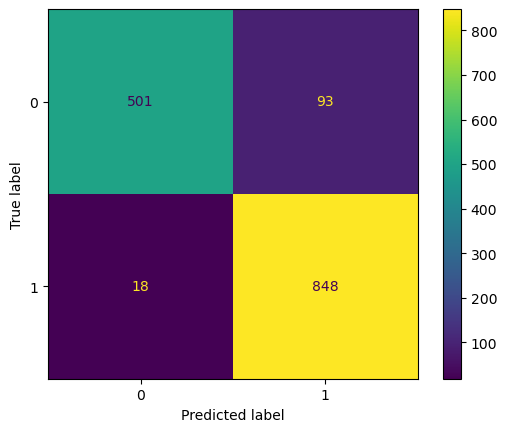

In [8]:
y_pred = clf.predict(X)

disp = infer.run(imputed_df)
disp.plot()
# save the figure to repo
disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
# write the figure to model card
#model_card.add_plot(**{"Confusion Matrix": "confusion_matrix.png"})

In [9]:
model_card.add_plot(**{"Confusion Matrix": "confusion_matrix.png"})

Card(
  model=RandomForestClassifier(),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=model.pkl,
  metadata.widget={...},
  Model description/Training Procedure/Hyperparameters=TableSection(18x2),
  Model description/Training Procedure/...</pre></div></div></div></div></div>,
  Model description/Evaluation Results=TableSection(2x2),
  model_description=This is a RandomFor...n student academic performance data.,
  limitations=This model is trained for educational purposes.,
  Confusion Matrix=PlotSection(confusion_matrix.png),
)

In [10]:
model_card.save(Path(local_repo) / "README.md")

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
hub_utils.push(repo_id = "sulpha/student_academic_success",
               source = local_repo,
               create_remote = True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

model.pkl:   0%|          | 0.00/6.86M [00:00<?, ?B/s]